In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms

import numpy as np

import matplotlib.pyplot as plt

from poutyne.framework import Model
from poutyne.framework.callbacks import Callback

from pathlib import Path

from PIL import Image

## Loading the data

This is a dataset with sign language digits from https://github.com/ardamavi/Sign-Language-Digits-Dataset

![](https://raw.githubusercontent.com/ardamavi/Vocalize-Sign-Language/master/Assets/Ours%20Dataset%20Preview.jpg)

Lets setup dataloaders and datasets:

In [78]:
data_dir = Path('data/sign-language')

imagenet_stats = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] # imagenet pixel mean and std deviation

valid_transforms = transforms.Compose([
    transforms.Resize(100),
    transforms.CenterCrop(100),
    transforms.ToTensor(),
    transforms.Normalize(*imagenet_stats)
])

train_transforms = transforms.Compose([
    transforms.Resize(100),
    transforms.CenterCrop(100),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(contrast=(0.9, 1.1)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    # TODO: add more/other augmentations here
    transforms.ToTensor(),
    transforms.Normalize(*imagenet_stats)
])

train_data = datasets.ImageFolder(
    data_dir / 'train', 
    train_transforms
)
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=64, shuffle=True, num_workers=4)

valid_data = datasets.ImageFolder(
    data_dir / 'valid', 
    valid_transforms
)
valid_loader = torch.utils.data.DataLoader(
    valid_data, batch_size=128, shuffle=True, num_workers=4)

train_data

Dataset ImageFolder
    Number of datapoints: 1662
    Root Location: data\sign-language\train
    Transforms (if any): Compose(
                             Resize(size=100, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(100, 100))
                             RandomHorizontalFlip(p=0.5)
                             ColorJitter(brightness=None, contrast=(0.9, 1.1), saturation=None, hue=None)
                             RandomRotation(degrees=(-10, 10), resample=False, expand=False)
                             RandomAffine(degrees=(0, 0), translate=(0.1, 0.1))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

## Look at the data

Lets grab a batch of data and take a look at the data

In [79]:
X, y = next(iter(train_loader))
X.shape

torch.Size([64, 3, 100, 100])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


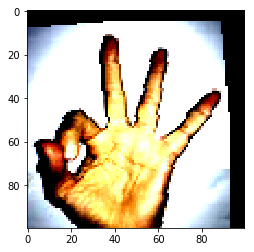

In [80]:
plt.imshow(X[0].permute(1, 2, 0).numpy())

The colors of the image seem strange since it is already normalized according to the imagenet statistics. We need to denormalize it to see the original image:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


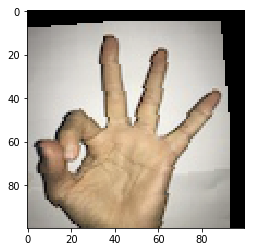

In [81]:
def denormalize(x):
    return (x * imagenet_stats[1]) + imagenet_stats[0]
    
plt.imshow(denormalize(X[0].permute(1, 2, 0).numpy()))

Lets take a look at some images and their labels.

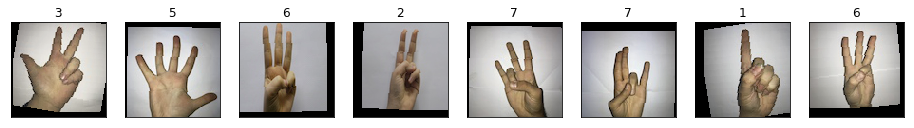

In [82]:
def to_rgb(x):
    return np.clip(denormalize(x.permute(1, 2, 0).numpy()), 0, 1)

plt.figure(figsize=(16, 4))
for X, y in train_loader:
    X = X[:8]
    for i, (img, lbl) in enumerate(zip(X, y)):
        plt.subplot(1, len(X), i+1)
        plt.title(str(lbl.item()))
        plt.imshow(to_rgb(img))
        plt.xticks([])
        plt.yticks([])
    break

## Preparing a Resnet for Finetuning

Lets load the pretrained ResNet18 model:

In [113]:
resnet = models.resnet18(pretrained=True)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

The first step in pretraining is to "freeze" all the layers. We can do this by setting the requires_grad property to False. During training, gradients for these layers are not computed and the optimizer will not update the layer weights.

In [114]:
for param in resnet.parameters():
    param.requires_grad = False

We now want to replace the original 1000-way classifier layer with our own version. We will only train this new "head" of the network. Luckily for us, the ResNet in PyTorch has a property called "fc" (fully connected) that corresponds to the original classification head:

In [115]:
resnet.fc

Linear(in_features=512, out_features=1000, bias=True)

Lets replace this with our own custom head. 

To get even better results, you could replace this sub-network with additional layers: use nn.Linear, nn.BatchNorm1d, nn.Dropout and nn.ReLU!

In [116]:
# replace fully connected layer
resnet.fc = nn.Sequential(
    nn.Linear(512, 256, bias=True),
    nn.BatchNorm1d(256),
    nn.Dropout(p=0.25),
    nn.ReLU(),
    
    nn.Linear(256, 256, bias=True),
    nn.BatchNorm1d(256),
    nn.Dropout(),
    nn.ReLU(),
    
    nn.Linear(256, 10, bias=True),
)
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

## Training the model - custom train loop

Lets train the model. I built my own train-loop here, the train loop using poutyne may be found further down:

In [117]:
for p in resnet.layer4.parameters():
    p.requires_grad = True

# put complete model into eval mode (important for batchnorm) and on GPU
resnet.eval()
resnet = resnet.cuda()

# setup optimizer
sgd = optim.SGD(
    [
        {'params': resnet.layer4.parameters(), 'lr': 1.e-2},
        {'params': resnet.fc.parameters(), 'lr': 1e-1}
    ],
    momentum=0.9, nesterov=True,
    weight_decay=1.e-4
)



def train(n_epochs):
    dataloaders = {
        'train': train_loader,
        'valid': valid_loader,
    }
    
    for epoch in range(10):
        print(f'Epoch {epoch}: ', end='')

        for phase in ['train', 'valid']:
            if phase == 'train':
                # put only head in train mode
                resnet.fc.train()
                resnet.layer4.train()
            else:
                resnet.fc.eval()
                resnet.layer4.eval()

            # keep track of loss and accuracy during epoch
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # move batch to gpu
                inputs = inputs.cuda()
                labels = labels.cuda()
                # don't forget to zero your gradients
                sgd.zero_grad()
                # disable backprop during validation
                with torch.set_grad_enabled(phase == 'train'):
                    # forward bass
                    outputs = resnet(inputs)
                    # compute loss
                    loss = F.cross_entropy(outputs, labels)
                # compute predictions
                preds = torch.argmax(outputs, dim=1)
                # compute loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                # backward pass
                if phase == 'train':
                    loss.backward()
                    sgd.step()

            # output loss and accuracy
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), 
                  end=(' | ' if phase == 'train' else '\n'))
            

train(10)

Epoch 0: train Loss: 1.3305 Acc: 0.5283 | valid Loss: 0.5817 Acc: 0.7950
Epoch 1: train Loss: 0.5824 Acc: 0.7894 | valid Loss: 0.4605 Acc: 0.8525
Epoch 2: train Loss: 0.3928 Acc: 0.8610 | valid Loss: 0.2102 Acc: 0.9250
Epoch 3: train Loss: 0.3392 Acc: 0.8863 | valid Loss: 0.1637 Acc: 0.9450
Epoch 4: train Loss: 0.3072 Acc: 0.8947 | valid Loss: 0.3683 Acc: 0.9000
Epoch 5: train Loss: 0.2503 Acc: 0.9170 | valid Loss: 0.1051 Acc: 0.9775
Epoch 6: train Loss: 0.2026 Acc: 0.9332 | valid Loss: 0.0975 Acc: 0.9700
Epoch 7: train Loss: 0.1954 Acc: 0.9350 | valid Loss: 0.1996 Acc: 0.9450
Epoch 8: train Loss: 0.2169 Acc: 0.9356 | valid Loss: 0.0955 Acc: 0.9700
Epoch 9: train Loss: 0.1842 Acc: 0.9368 | valid Loss: 0.1345 Acc: 0.9650


## Training using Poutyne

Unfortunately, training directly with poutyne results in some problems. This is because poutyne will call resnet.train() before it's trianing epoch, which puts all BatchNorm layers in train mode. Even if those batchnorm layers do not have their gradients updated (since they're set to requires_grad=False), in train mode the BatchNorm layer will still update its running mean and standard deviation. At least here this results in bad accuracy. This is not documented in most tutorials about transfer learning and many tutorials will put their complete model in train mode when finetuning only the head of the model. 

The workaround here is to explicitely put all BatchNorm2d layers into eval mode using a callback:

In [12]:
class CompleteFreeze(Callback):
    def on_batch_begin(self, *args):
        for l in resnet.modules():
            if not any(p.requires_grad for p in l.parameters()):
                l.train(False)
                

sgd = optim.SGD(
    resnet.parameters(), 
    lr=1.e-1, weight_decay=1.e-4, momentum=0.9, nesterov=True
)

model = Model(resnet, sgd, 'cross_entropy', metrics=['accuracy']) 
model.cuda() 
model.fit_generator(
    train_loader, valid_loader,
    epochs=10, callbacks=[CompleteFreeze()]
)

Epoch 1/10 1.45s Step 26/26: loss: 0.286815, acc: 95.487364, val_loss: 1.428432, val_acc: 87.500000
Epoch 2/10 1.31s Step 26/26: loss: 0.250119, acc: 96.389892, val_loss: 1.176442, val_acc: 90.500000
Epoch 3/10 1.32s Step 26/26: loss: 0.256058, acc: 96.329723, val_loss: 2.885555, val_acc: 83.000000
Epoch 4/10 1.33s Step 26/26: loss: 0.370383, acc: 95.066185, val_loss: 1.681469, val_acc: 87.250000
Epoch 5/10 1.41s Step 26/26: loss: 0.149062, acc: 97.412756, val_loss: 1.343123, val_acc: 89.000000
Epoch 6/10 1.31s Step 26/26: loss: 0.177077, acc: 96.750902, val_loss: 1.546148, val_acc: 88.500000
Epoch 7/10 1.37s Step 26/26: loss: 0.113313, acc: 96.931408, val_loss: 2.110240, val_acc: 86.000000
Epoch 8/10 1.46s Step 26/26: loss: 0.239534, acc: 95.306859, val_loss: 1.295189, val_acc: 87.750000
Epoch 9/10 1.38s Step 26/26: loss: 0.124571, acc: 98.074609, val_loss: 1.409337, val_acc: 88.250000
Epoch 10/10 1.41s Step 26/26: loss: 0.196471, acc: 96.871239, val_loss: 1.430099, val_acc: 89.000000

[{'epoch': 1,
  'loss': 0.2868148376795359,
  'time': 1.4549844409921207,
  'acc': 95.48736443731903,
  'val_loss': 1.428432149887085,
  'val_acc': 87.5},
 {'epoch': 2,
  'loss': 0.25011911634557515,
  'time': 1.3108586099988315,
  'acc': 96.38989166920796,
  'val_loss': 1.1764418411254882,
  'val_acc': 90.5},
 {'epoch': 3,
  'loss': 0.25605777225196,
  'time': 1.31791741901543,
  'acc': 96.32972329847793,
  'val_loss': 2.885555000305176,
  'val_acc': 83.0},
 {'epoch': 4,
  'loss': 0.3703826555419628,
  'time': 1.3278125160140917,
  'acc': 95.06618526380701,
  'val_loss': 1.6814694690704346,
  'val_acc': 87.25},
 {'epoch': 5,
  'loss': 0.1490623781711948,
  'time': 1.4125257499981672,
  'acc': 97.41275571600481,
  'val_loss': 1.343123435974121,
  'val_acc': 89.0},
 {'epoch': 6,
  'loss': 0.1770768277481575,
  'time': 1.3097919449792244,
  'acc': 96.7509023434562,
  'val_loss': 1.5461481857299804,
  'val_acc': 88.5},
 {'epoch': 7,
  'loss': 0.11331268803414886,
  'time': 1.3736180450068

## Predict on your image!

Lets see if the network learnt to recognize sign language, and if you learnt some sign language yourself ;-) First, load an image from disc:

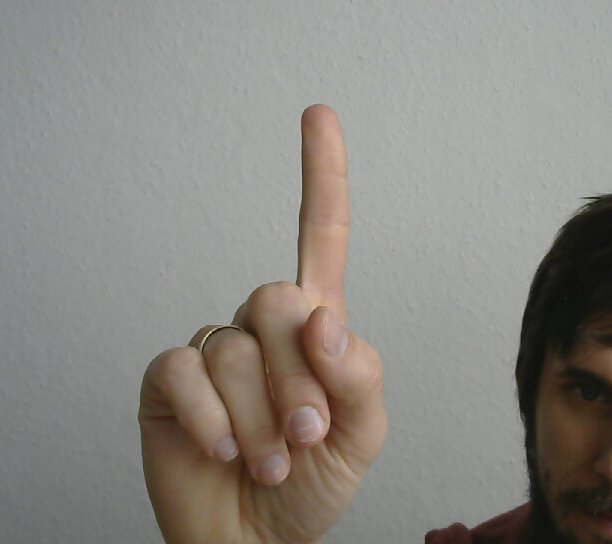

In [88]:
img = Image.open('one.jpg')
img

One important detail here is that we should now do the same transformations, that means especially normalizing according to the imagenet statistics. We can just call our transforms object to do this:

In [89]:
img_tensor = valid_transforms(img)
img_tensor.shape

torch.Size([3, 100, 100])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


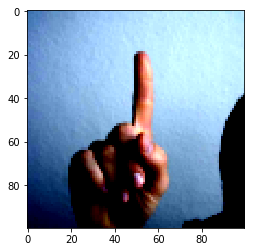

In [90]:
plt.imshow(img_tensor.permute(1, 2, 0))

Lets pass the image through our trained resnet:

In [91]:
resnet.eval()
resnet = resnet.cuda()
out = resnet(valid_transforms(img)[None].cuda())
out

tensor([[ 3.3244, 19.3433,  1.7690, -4.8003, -4.2570, -4.1012, -3.4228, -7.1330,
          0.2904,  1.0817]], device='cuda:0', grad_fn=<AddmmBackward>)

In [92]:
out.argmax()

tensor(1, device='cuda:0')

In [93]:
F.softmax(out, dim=1)

tensor([[1.1043e-07, 1.0000e+00, 2.3312e-08, 3.2703e-11, 5.6299e-11, 6.5794e-11,
         1.2966e-10, 3.1731e-12, 5.3139e-09, 1.1725e-08]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

Lets put this into a function that we can reuse:

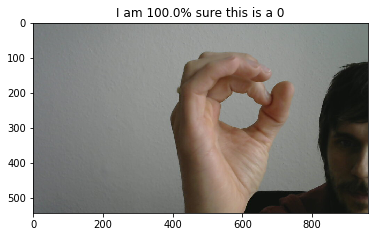

In [94]:
def predict_finger_digit(fn):
    img = Image.open(fn).convert('RGB')
    resnet.eval()
    out = resnet(valid_transforms(img)[None].cuda())
    cls = out.argmax().item()
    pct = 100 * F.softmax(out, dim=1)[0, cls]
    
    plt.title(f"I am {pct:.1f}% sure this is a {cls}")
    plt.imshow(img)
    
predict_finger_digit('zero.jpg')

# Your Tasks

- Test this with your own image(s). Make a photo (e.g. with your smartphone), and pass it through the network.
- How well does this work when you do not use pretrained weight? (set pretrained=False when loading resnet and train the whole model)
- Is the model underfitting, overfitting, or is it just right?
- If it is overfitting, try this:
  - Add data augmentation (be sure to re-run the data-loader cells for that) - see https://pytorch.org/docs/stable/torchvision/transforms.html#transforms-on-pil-image I'd especially recomment RandomHorizontalFlip & RandomAffine, ColorJitter might also be interesting. Remember to only apply it to the train loader ;-)
  - Add regularization to your head, e.g. add Dropout (it is usually a good idea to put dropout after batchnorm and use values in the range 0.25 - 0.5 for the p value)
- If overfitting is not an issue, try this:
  - Add more layers to your classification head. Experiment with Dropout, add Batchnorm, add more nn.Linear. For example, try the following head: batchnorm -> dropout -> linear -> relu -> batchnorm -> dropout -> linear
  - "Unfreeze" additional layers of the ResNet, e.g. all modules in "resnet.layer4"
- Train this dataset with the model that you used for MNIST, from scratch. How well does it work?
- Train it on a dataset for emotion recognition - called oulu-casia (in the same data folder)
  
Bonus:
- What classes is the model good at, where is the model bad? Plot a confusion matrix on the validation set.
- Try other base-architectures. resnet34, resnet101, resnet50, resnet152 should all be easy, but there are many more available in PyTorch: https://pytorch.org/docs/stable/torchvision/models.html Some might require building the classification head in a different way.
- Build an application that grabs a video from your webcam and classifies it.
- How would you add a "ackground" class to the dataset, so that the network can recognize if there is actually no hand in the image.
- The current architecture requires that the hand is in the middle of the image and relatively large. How would you implement a CNN that first detects the hand, so that you can crop the image before giving it to your classification network?
 